In [1]:
import sys
import os
import cv2 as cv
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from CoffeeNet.dataset.dataset import CoffeeDataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
train_images_names = os.listdir('../data/processed/images/train/')
train_mask_names = os.listdir('../data/processed/annotations/train/')
# sort
train_mask_names = [image.split('.')[0]+"_mask.png" for image in train_images_names]

In [5]:
train_dataframe = pd.DataFrame({'images':train_images_names,'masks':train_mask_names})

In [6]:
train_dataframe['images'] = train_dataframe['images'].apply(lambda x: os.path.join('../data/processed/images/train/',x))

In [7]:
train_dataframe['masks'] = train_dataframe['masks'].apply(lambda x: os.path.join('../data/processed/annotations/train/',x))

In [8]:
train_dataframe.sample(20)

,images,masks
29,../data/processed/images/train/1422.jpg,../data/processed/annotations/train/1422_mask.png
107,../data/processed/images/train/28.jpg,../data/processed/annotations/train/28_mask.png
335,../data/processed/images/train/343.jpg,../data/processed/annotations/train/343_mask.png
150,../data/processed/images/train/1487.jpg,../data/processed/annotations/train/1487_mask.png
69,../data/processed/images/train/1546.jpg,../data/processed/annotations/train/1546_mask.png
262,../data/processed/images/train/1666.jpg,../data/processed/annotations/train/1666_mask.png
100,../data/processed/images/train/358.jpg,../data/processed/annotations/train/358_mask.png
165,../data/processed/images/train/1531.jpg,../data/processed/annotations/train/1531_mask.png
312,../data/processed/images/train/397.jpg,../data/processed/annotations/train/397_mask.png
386,../data/processed/images/train/967.jpg,../data/processed/annotations/train/967_mask.png


In [9]:
import json
with open('../data/external/annotations-info.json') as f:
    annotation_info = json.load(f)
annotation_info

{'background': [0, 0, 0], 'leaf': [0, 176, 0], 'symptom': [255, 0, 0]}

In [32]:
import random
img,leaf,symptom = CoffeeDataset(train_dataframe,annotation_info)[random.randint(0,len(train_dataframe)-1)]

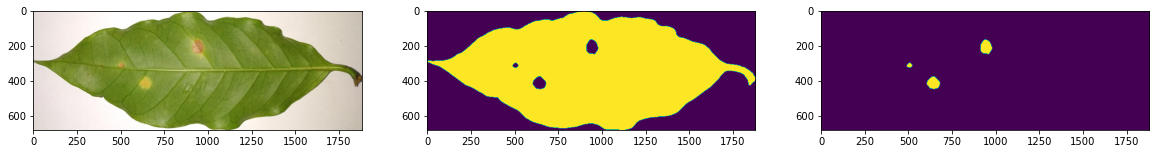

In [33]:
fig,axs = plt.subplots(1,3,figsize=(20,50))
axs[0].imshow(img)
axs[1].imshow(leaf,"gray")
axs[2].imshow(symptom,"gray")